In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import mcu
import cylinder_dataset_generator as cyl
import dataset_generator


In [14]:
figure_num = 300
figure_point_cnt = 300
deterministic_param_scatter = False
p = 3
sorted = True
deterministic_scatter = True
lw = np.array([1, 1, 0])
up = np.array([10, 10, 45])
param_names = np.array(["height", "radius", "angle_x"])
control_vars = dataset_generator.get_control_vars(deterministic=deterministic_param_scatter, dimensionality=p,
                                                  size=figure_num,
                                                  lw=lw, up=up)
control_vars_dict = dataset_generator.put_control_vars_in_dict(control_vars, p, param_names)
figures = dataset_generator.generate_array_of_figures(control_vars_dict, cyl.generate_cylinder_points, noise_level=0,
                                                      min_num_points=figure_point_cnt)
k = 6
c = 12000
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, figures, k)

q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges, c)

0.08739029708105606


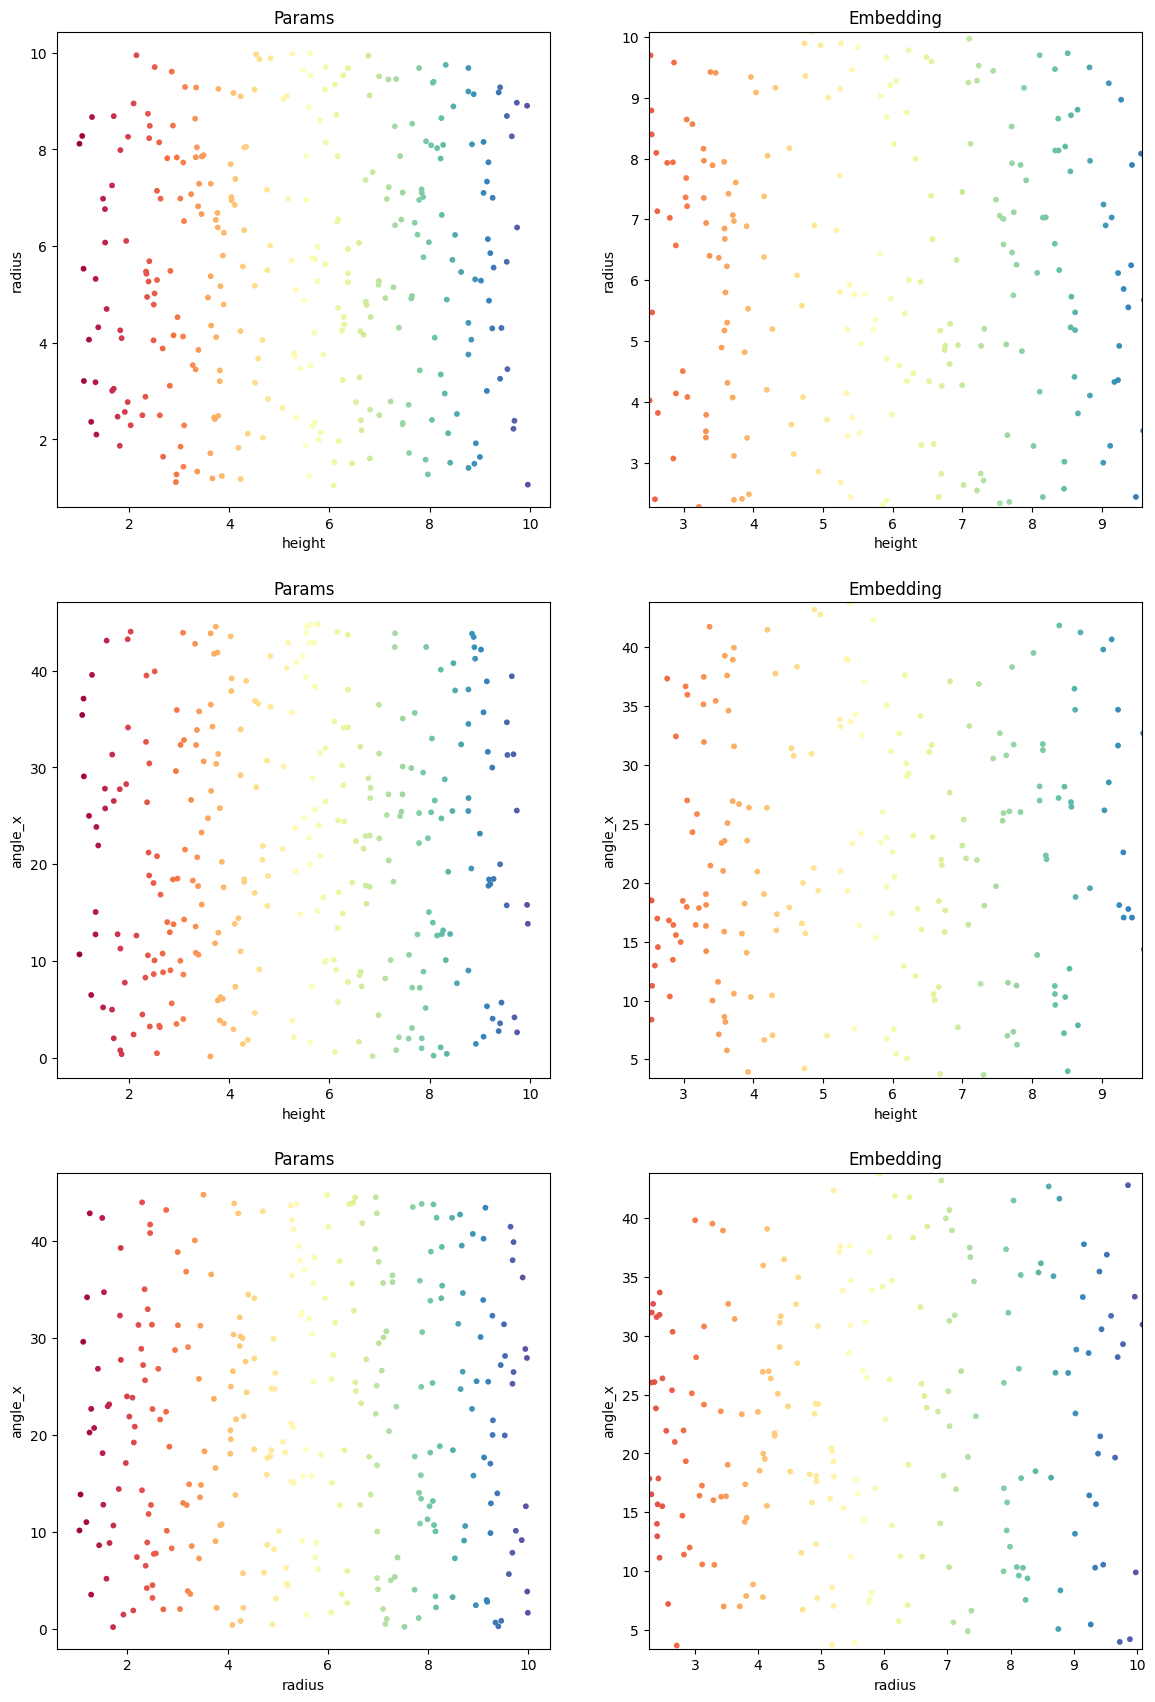

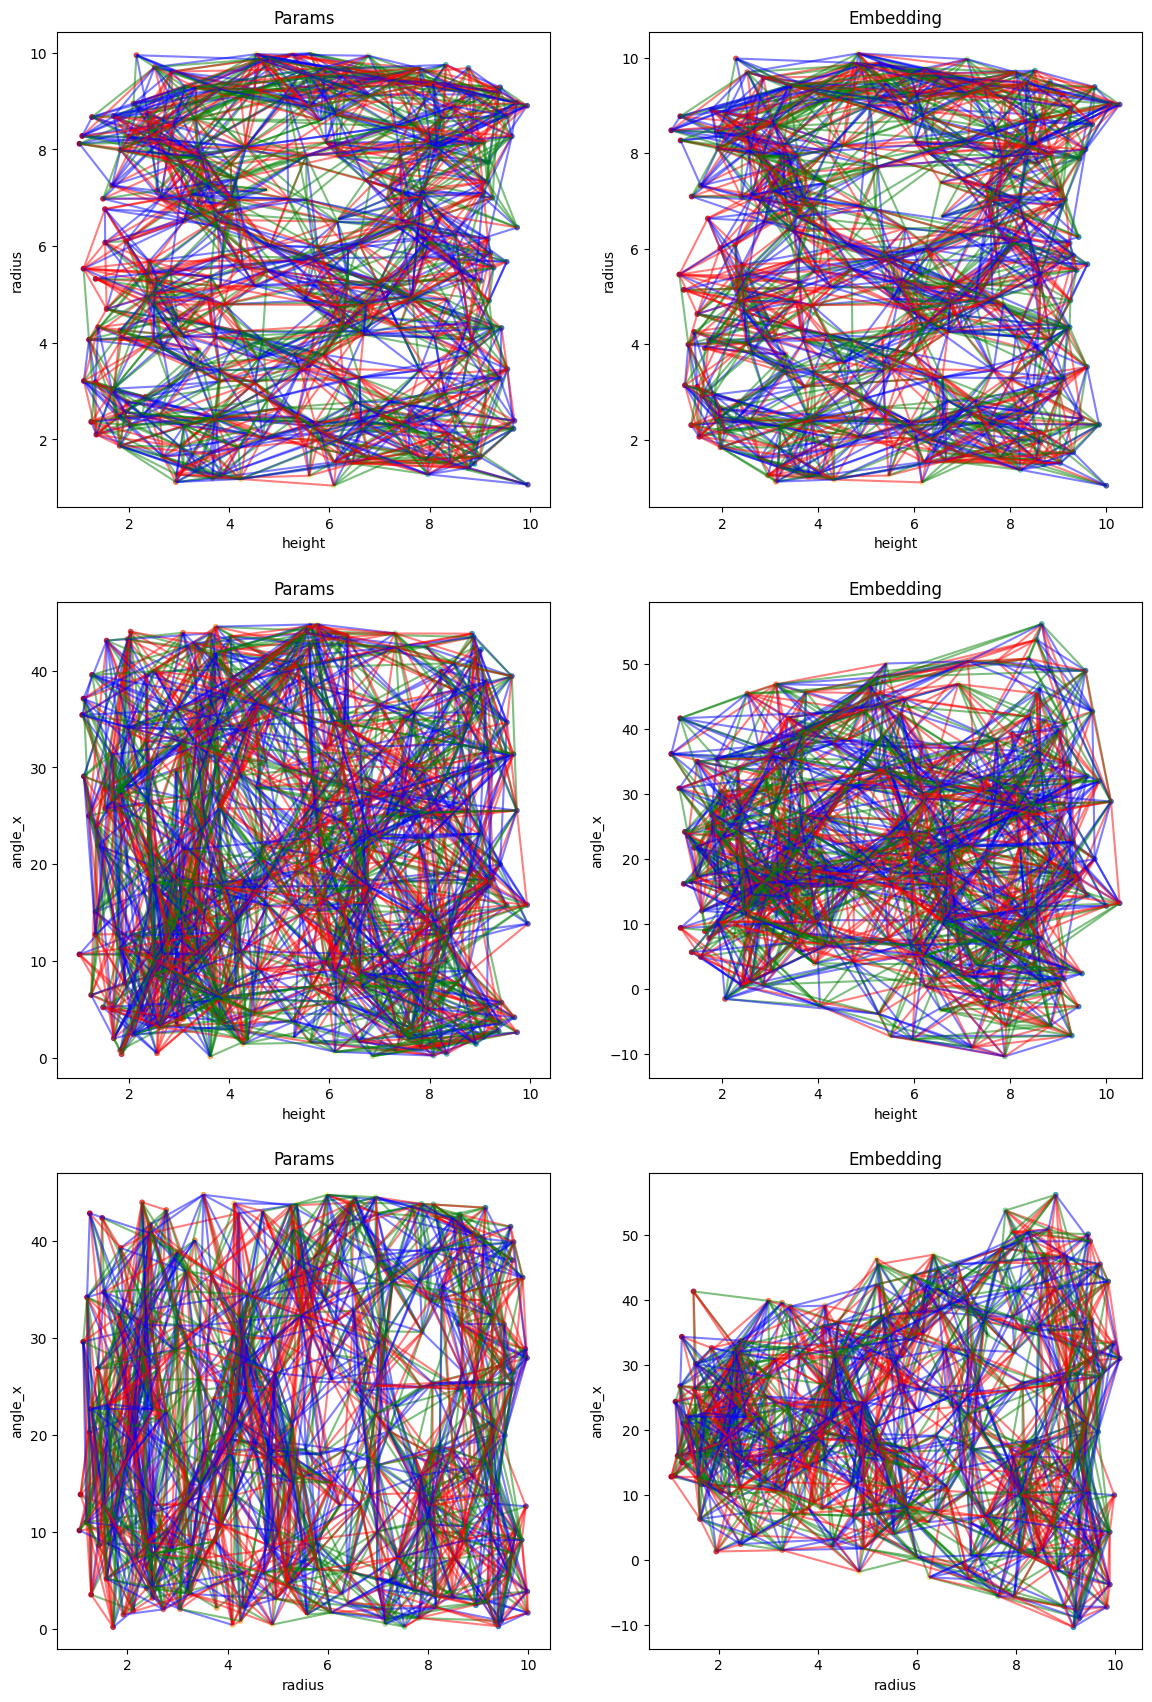

In [15]:
ld_embedding = mcu.reduce_dimensions(q, p)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

ld_embedding_to_params = np.dot(ld_embedding, np.linalg.inv(regression_matrix)) * x_stds + x_means

rre = mcu.compute_rre(ld_embedding_to_params, control_vars)
print(np.median(rre))
mcu.plot_embeddings_vs_parameters(embedding=ld_embedding_to_params, params=control_vars, param_names=param_names)
mcu.plot_embeddings_vs_parameters(embedding=ld_embedding_to_params, params=control_vars, param_names=param_names,
                                  edges=edges)

In [16]:
pieces_cnt = 5
test_data_size = 20
noise_level = 0.1
interval_runs, intervals = mcu.test_predictive_optimization(lw, up, p, k, cyl.generate_cylinder_points,
                                                            figure_point_cnt,
                                                            centered_y, ld_embedding, regression_matrix, y_means,
                                                            y_scaler,
                                                            x_stds, x_means, param_names, noise_level, pieces_cnt,
                                                            test_data_size,
                                                            same_value=False)

-----------
x_opt  = [ 3.03487624  2.20582265 18.90257208], x_err = 37.339194732078155
x_real = [2.0882217  1.60381745 6.51413129]
-----------
x_opt  = [ 2.22414054  2.28132014 18.51509639], x_err = 9.850491842290424
x_real = [1.54692572 2.37216831 7.55507457]
-----------
x_opt  = [ 3.14380184  2.20582265 17.45301697], x_err = 36.02481160830557
x_real = [2.11426406 1.19528268 2.16863125]
-----------
x_opt  = [ 3.20732719  2.4781713  20.19750335], x_err = 7.5498033345102264
x_real = [1.07285037 1.25592283 0.23243786]
-----------
x_opt  = [ 2.22414054  2.54444264 22.67219183], x_err = 12.407115711360454
x_real = [1.4539414  1.91722338 3.57989354]
-----------
x_opt  = [ 2.42941954  2.20582265 16.20831039], x_err = 4.1967287186257805
x_real = [2.28167631 2.19338191 5.7280064 ]
-----------
x_opt  = [ 3.13413522  2.20582265 17.39876747], x_err = 136.55937102439256
x_real = [2.78421692 1.44168542 7.60681136]
-----------
x_opt  = [ 2.22414054  2.20582265 17.65394302], x_err = 10.60868980024528

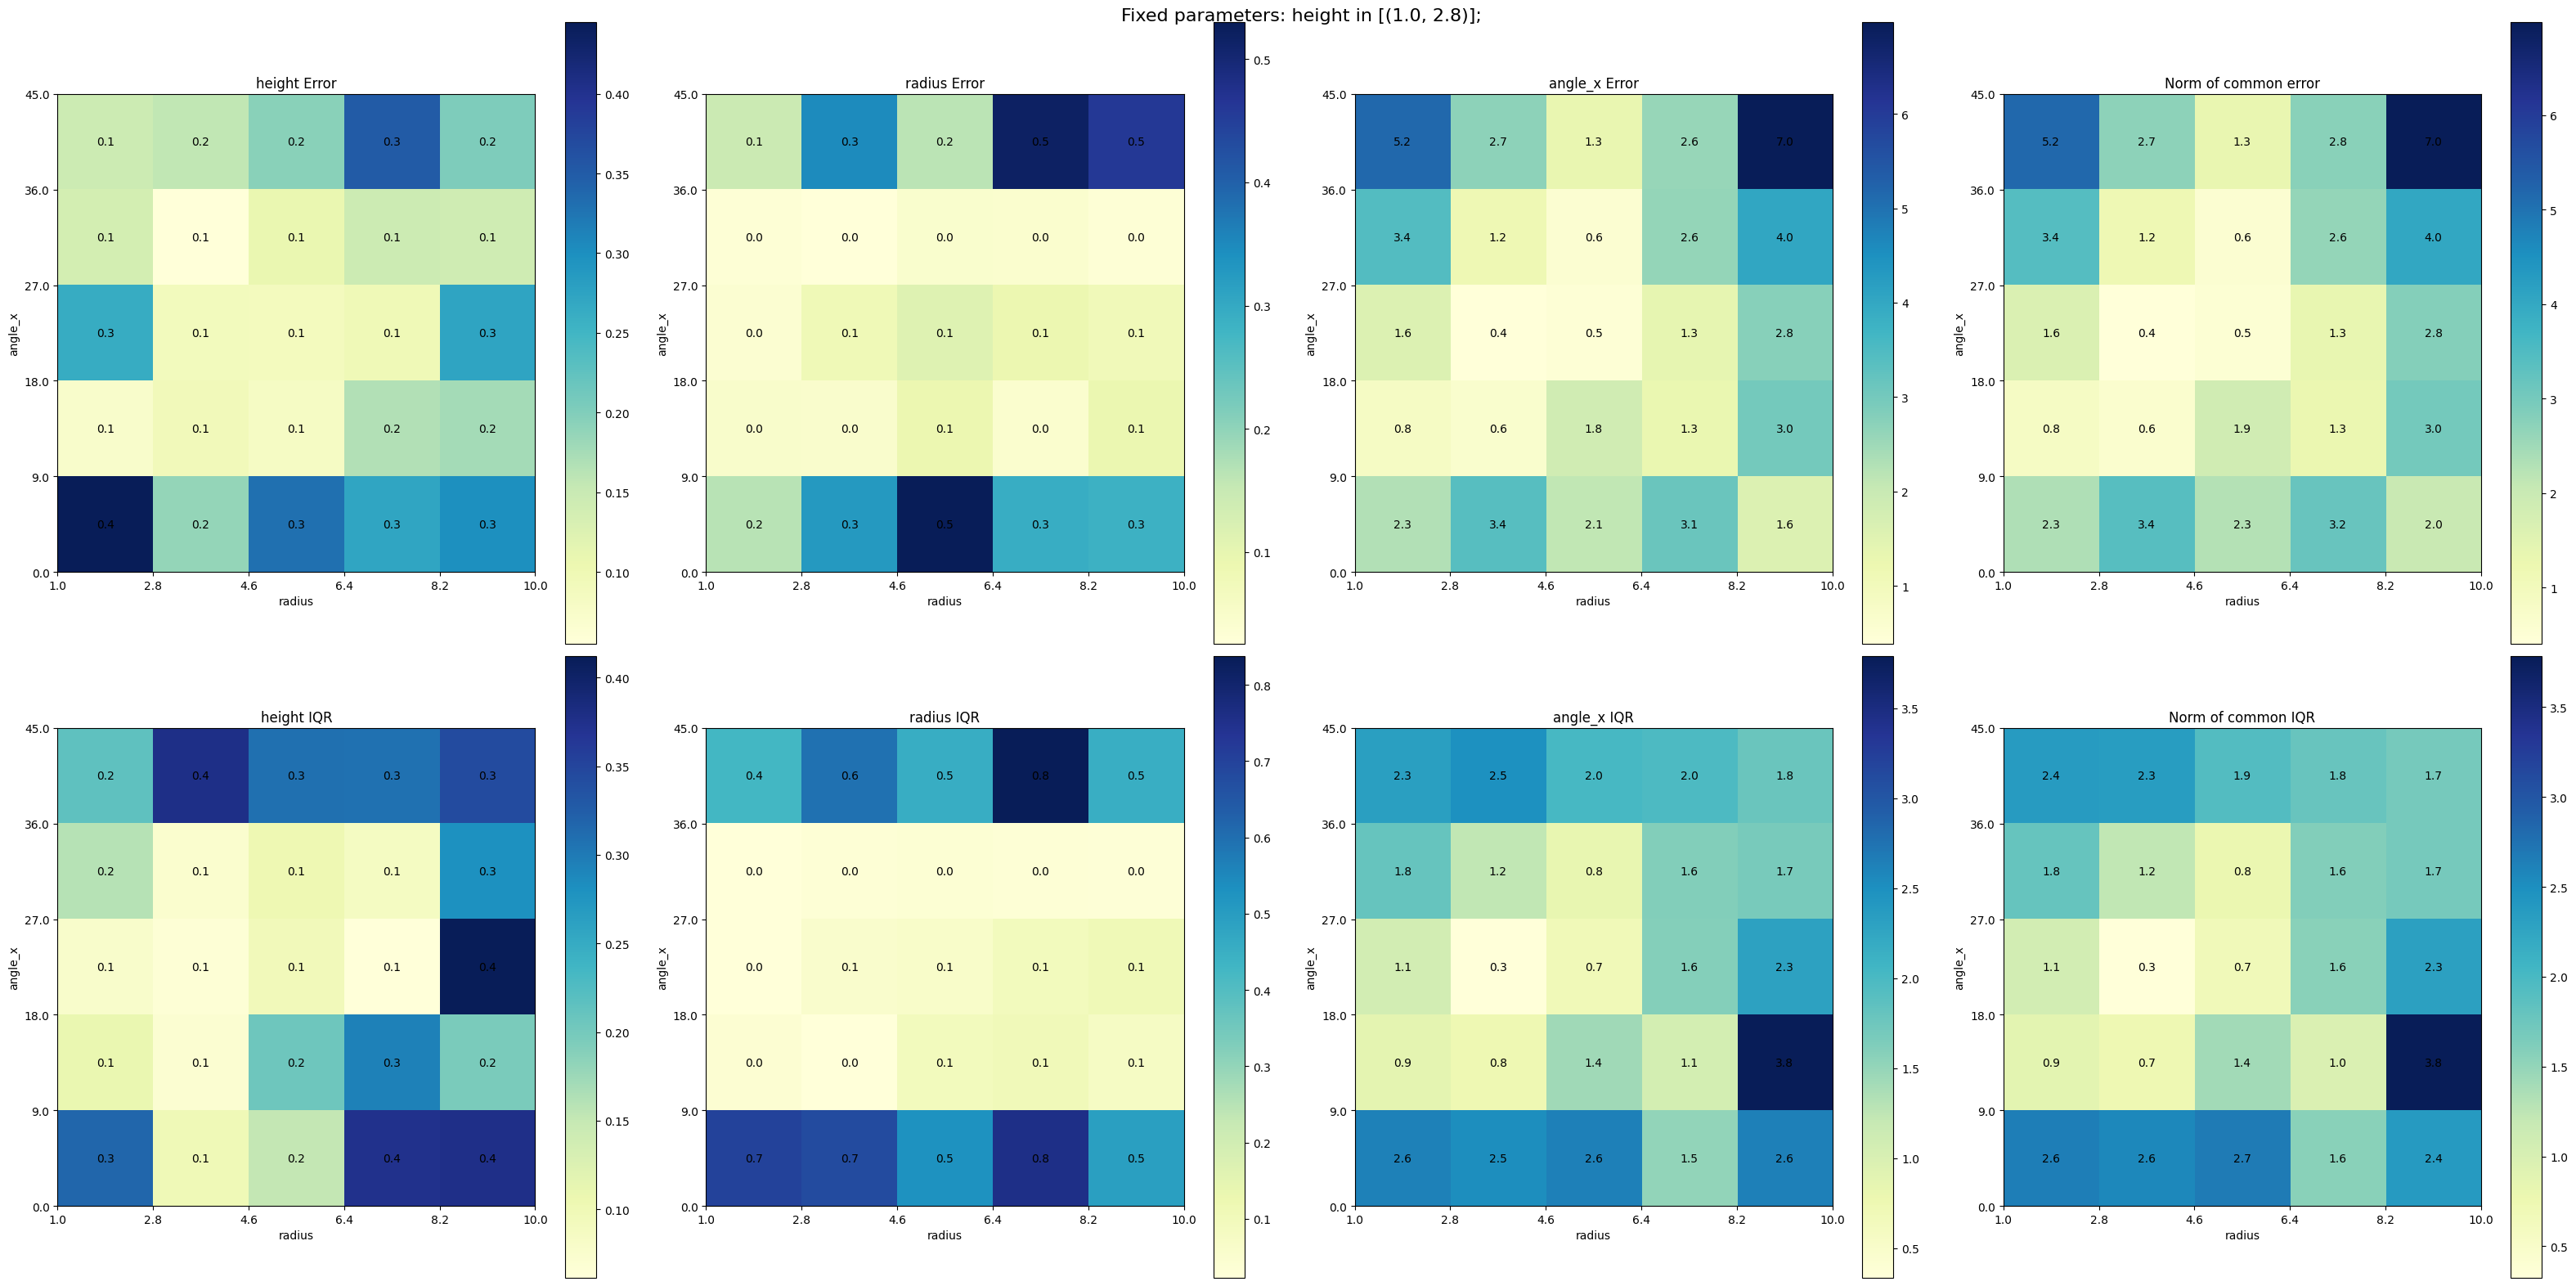

In [18]:
mcu.plot_2d_predictive_optimization_heatmaps(lw, up, pieces_cnt, interval_runs, p, param_names, fixed_params_map={0: 2},
                                             intervals=intervals)